In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [2]:
from models import simpleModel, stepModel, spatialModelFracConn, spatialModelNO2, spatialModelNO2alpha, minimize, msse, getMsseRelative
from plotting import plotSim, plotSimLks, plotSimLksCuml

In [3]:
data = gpd.read_file('./data/landkreise_no2_14d.json')
dateColNames = data.columns[5:-10]

In [4]:
incubationTime = 7
t_curfew = np.where(dateColNames == '22.03.2020')[0][0]
t_curfew_effect = t_curfew + incubationTime

## 1. Simple model

This model does ok for cumulative data.
But results are terrible if we try to use the same alpha for deaggregated LKs.
The reason is mostly n0: most LKs don't initially have any infections, so this model always predicts 0 for these LKs.

When used for cumulative data, the simple model will always overestimate alpha, because it must compensate for those LKs that have n0 == 0. When used for deaggregated data, this model will effectively only calibrate on to those LKS with n0 != 0.

In [5]:
n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
population = data['population'].values
Ks = population
n0 = n_obs[:, 0]

Let's first see how well that model does at predicting all of Germany.

In [6]:
n_obs_cuml = np.sum(n_obs, axis=0).reshape((1, nrTimesteps))
population_cuml = np.sum(population)
K_cuml = population_cuml
n0_cuml = n_obs_cuml[:, 0]

In [7]:
results_simple_cuml, history_simple_cuml = minimize(n_obs_cuml, simpleModel, [0.18], [(0.0001, 1.0000)], [1, nrTimesteps, K_cuml, n0_cuml], msse)
results_simple_cuml

      fun: 14227210870.19923
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-17929.07714844])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 26
      nit: 4
   status: 0
  success: True
        x: array([0.18259509])

In [8]:
n_sim_simple_cuml = simpleModel(results_simple_cuml.x[0], 1, nrTimesteps, K_cuml, n0_cuml)

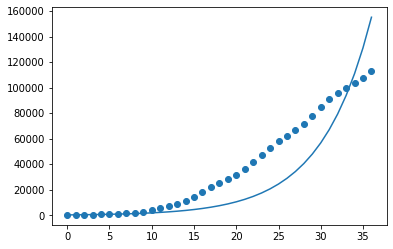

In [9]:
t = np.arange(nrTimesteps)
plt.scatter(t, n_obs_cuml)
plt.plot(t, n_sim_simple_cuml[0])

Now let's see how good the model is at predicting local values.

In [10]:
msseRelPop = getMsseRelative(population / 10000)
results_simple, history_simple = minimize(n_obs, simpleModel, [0.18], [(0.0001, 1.0000)], [nrPlaces, nrTimesteps, Ks, n0], msseRelPop)
results_simple

      fun: 868937.278821977
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.01164153])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 7
   status: 0
  success: True
        x: array([0.09755405])

In [11]:
n_sim_simple = simpleModel(results_simple.x[0], nrPlaces, nrTimesteps, Ks, n0)
sseRelPop(n_obs, n_sim_simple)

NameError: name 'sseRelPop' is not defined

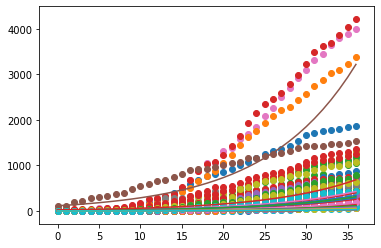

In [12]:
t = np.arange(nrTimesteps)
for i in range(0, nrPlaces):
    if n_obs[i, 0] != 0:
        plt.scatter(t, n_obs[i])
        plt.plot(t, n_sim_simple[i])

When we use the simple model to predict local values, we get ok predictions for all those places that have n0 != 0.
When we use instead the value of alpha that fits cumulated values, we get a massive overestimation of those local values.



In [13]:
n_sim_simple_x = simpleModel(0.17, nrPlaces, nrTimesteps, Ks, n0)
msseRelPop(n_obs, n_sim_simple_x)

5416871.984594022

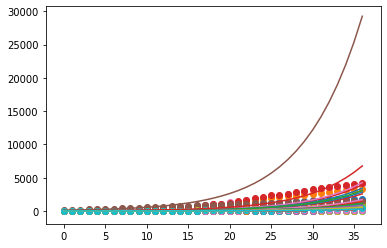

In [14]:
t = np.arange(nrTimesteps)
for i in range(0, nrPlaces):
    if n_obs[i, 0] != 0:
        plt.scatter(t, n_obs[i])
        plt.plot(t, n_sim_simple_x[i])

We can learn a few things from this:

  1. If we want to predict local values, we need to use a model that takes location and traffic explicitly into account.

  2. If we don't do that, we get a value for alpha that differs massively from the global one, because that non-global alpha is effectively only being calculated from the places that have n0 != 0

  3. Also note that these two models, although having the same sourcecode, have very different interpretations:
the cumulated model assumes perfect mixing between LKs, the deaggregated model assumes no mixing at all.

Before we work on bringing in spatial growth of the virus, however, we'll add a little tweak to the model, to account for the quarantaine measures.

## 2. Simple model with step in $\alpha$

This model does better in fitting to cumulative data, but suffers from the same shortcomings as the simple model when it comes to deaggregated data.

In [15]:
results_step_cuml, history_step_cuml = minimize(n_obs_cuml, stepModel, [0.22, 0.25], [(0.0001, 1.0000), (0.0001, 1.0000)], [1, nrTimesteps, K_cuml, n0_cuml, t_curfew_effect], msse)
results_step_cuml

      fun: 803695251.0067716
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1672303.67660522,  105214.11895752])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 15
   status: 0
  success: True
        x: array([0.22963906, 0.22929206])

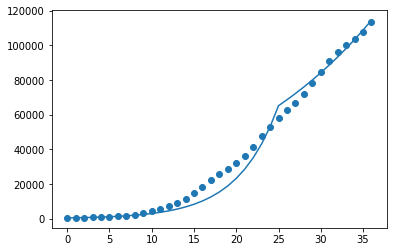

In [16]:
n_sim_step_cuml = stepModel(*(results_step_cuml.x), 1, nrTimesteps, K_cuml, n0_cuml, t_curfew_effect)
t = np.arange(nrTimesteps)
plt.scatter(t, n_obs_cuml)
plt.plot(t, n_sim_step_cuml[0])

In [17]:
results_step, history_step = minimize(n_obs, stepModel, [0.18, 0.25], [(0.0001, 1.0000), (0.0001, 1.0000)], [nrPlaces, nrTimesteps, Ks, n0, t_curfew_effect], msseRelPop)
results_step

      fun: 862096.8440938375
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.51808625, -0.11641532])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 14
   status: 0
  success: True
        x: array([0.11807989, 0.22821469])

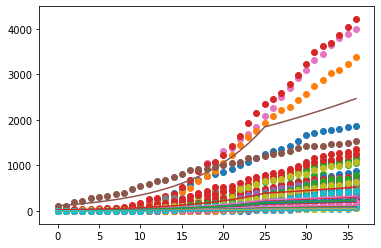

In [18]:
n_sim_step = stepModel(*(results_step.x), nrPlaces, nrTimesteps, Ks, n0, t_curfew_effect)
t = np.arange(nrTimesteps)
for i in range(0, nrPlaces):
    if n_obs[i, 0] != 0:
        plt.scatter(t, n_obs[i])
        plt.plot(t, n_sim_step[i])

Again, this model yields good results where n0 != 0, but is unusable for any other location. 

## 3. Spatial model

In [19]:
geometries = data.geometry
results_spatial, history_spatial = minimize(n_obs, spatialModelFracConn, [0.07, 0.5, 0.25, 0.5], [(0.01, 1), (0.1, 1), (0.1, 0.5), (0.01, 1)], [nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew], msseRelPop)
results_spatial

... 1 calls made ...
... 2 calls made ...
... 3 calls made ...


      fun: 526941.5271128456
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 95690.00685588,  10761.89801097, 149527.93717384,  12849.03846681])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 20
   status: 0
  success: True
        x: array([0.08096765, 0.5433805 , 0.14391069, 0.56808147])

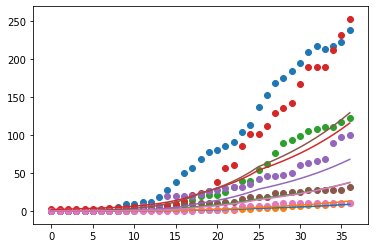

In [20]:
n_sim_spatial = spatialModelFracConn(*(results_spatial.x),
                        nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew)

for i in range(0, 20, 3):
    plt.scatter(t, n_obs[i])
    plt.plot(t, n_sim_spatial[i])

With this model we can finally obtain any meaningful values for LKs that did not initially have infections. But the fit isn't quite ideal. Let's see if we can do better with extra information about traffic.

## 4. Spatial model with connectivity reduction estimated from NO2

In [21]:
fractionNo2 = data['NO2_diff_frac'].values
results_no2, history_no2 = minimize(n_obs, spatialModelNO2, [0.08, 0.5, 0.18], [(0.01, 1), (0.1, 1), (0.1, 0.5)], [nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, fractionNo2], msseRelPop)
results_no2

      fun: 575832.4278478745
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-23.9466317 ,  -0.05820766, -11.88600436])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 16
   status: 0
  success: True
        x: array([0.08824257, 0.2378567 , 0.1197205 ])

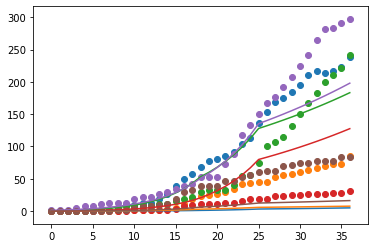

In [22]:
n_sim_no2 = spatialModelNO2(*(results_no2.x),
                        nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, fractionNo2)

for i in range(0, 30, 5):
    plt.scatter(t, n_obs[i])
    plt.plot(t, n_sim_no2[i])

## 5. Spatial model with NO2 and localized $\alpha$

In [29]:
results_alpha, history_alpha = minimize(n_obs, spatialModelNO2alpha, [0.2], [(0.01, 1)], [Ks, geometries, t_curfew_effect, t_curfew, n_obs, fractionNo2], msseRelPop)
results_alpha

      fun: 111393.78908722152
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00291038])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 6
   status: 0
  success: True
        x: array([0.35424496])

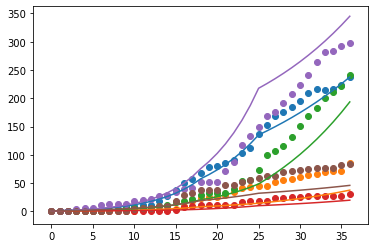

In [30]:
n_sim_alpha = spatialModelNO2alpha(*(results_alpha.x),
                    Ks, geometries, t_curfew_effect, t_curfew, n_obs, fractionNo2)

for i in range(0, 30, 5):
    plt.scatter(t, n_obs[i])
    plt.plot(t, n_sim_alpha[i])

## 6. Comparing predictions between all the models for a few LKs

We have created a series of models of increasing complexity. Let's compare how their predictions look for different LKs.